In [92]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.primitives import Sampler
from qiskit.visualization import plot_distribution
from qiskit import Aer, transpile

import matplotlib.pyplot as plt
import numpy as np

### Probability distribution:

C:\Users\marekowa\AppData\Local\Temp\ipykernel_31936\2607047249.py:22: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  risk_model.cnot(not_flooding, flooding, ctrl_state='0')
c:\Users\marekowa\AppData\Local\miniconda3\envs\q4\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


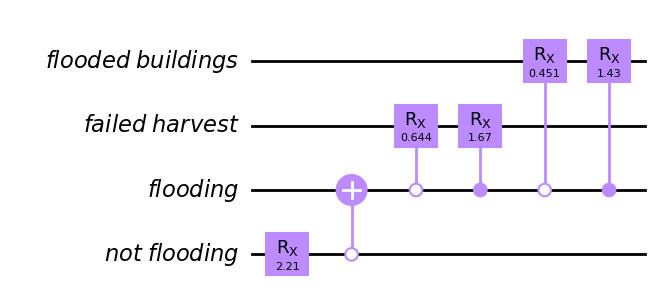

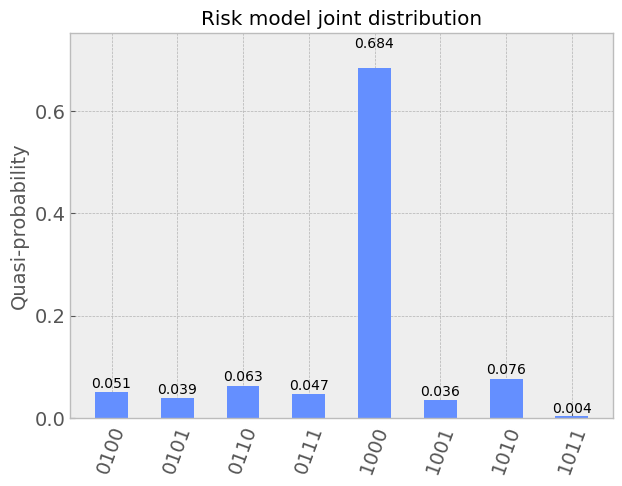

In [93]:
import qiskit as q


plt.style.use('ggplot')

# Make separate quantum qubits (for the naming)
not_flooding = q.QuantumRegister(1, name='not flooding')
flooding = q.QuantumRegister(1, name='flooding')
fld_buildings = q.QuantumRegister(1, name='flooded buildings')
failed_h = q.QuantumRegister(1, name='failed harvest')

# Helper converter function
p_to_theta = lambda x: 2*np.arcsin(np.sqrt(x))

# Create the circuit
risk_model = q.QuantumCircuit(fld_buildings, failed_h, flooding, not_flooding, name='Risk Model')

# Intrinsic not flooding
risk_model.rx(p_to_theta(0.8), not_flooding)

# Add the CNOT with the control state as '0'
risk_model.cnot(not_flooding, flooding, ctrl_state='0')

# The intrinsic probability for failed harvest occurs when there's no flooding
risk_model.crx(p_to_theta(0.1), flooding, failed_h, ctrl_state='0')

# Calculate the P(failed harvest | flooding)
p = 1 - (1 - 0.1) * (1 - 0.5)
risk_model.crx(p_to_theta(p), flooding, failed_h, ctrl_state='1')

# The same for flooded buildings
risk_model.crx(p_to_theta(0.05), flooding, fld_buildings, ctrl_state='0')
p = 1 - (1 - 0.05) * (1 - 0.4)
risk_model.crx(p_to_theta(p), flooding, fld_buildings, ctrl_state='1')

# Draw the circuit with matplotlib
display(risk_model.draw(output='mpl'))

risk_model.measure_all()

# simulator = Aer.get_backend('aer_simulator')
# job = simulator.run(risk_model, shots=None)

sampler = Sampler()
job = sampler.run(risk_model, shots=None)
qp = job.result().quasi_dists[0].binary_probabilities()
    

with plt.style.context('bmh'):
    display(plot_distribution(qp, title='Risk model joint distribution'))

C:\Users\marekowa\AppData\Local\Temp\ipykernel_31936\588332527.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  uji_qps[imp_idx]+= qps[qps_idx]


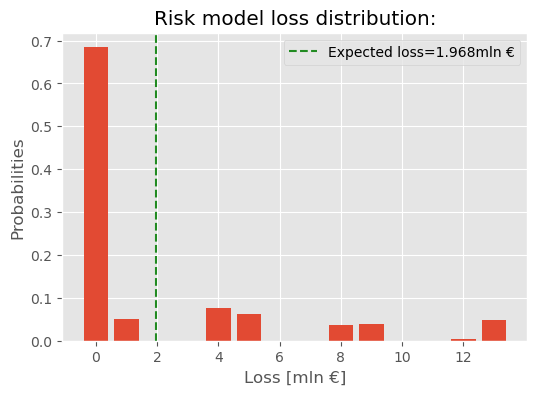

In [119]:
impacts = [8, 4, 1, 0][::-1]
n_events = len(impacts)


qps = np.zeros((2**n_events))

for key, value in qp.items():
    qps[int(key, base=2)] = value


occurencies = [format(i, f'0{n_events}b') for i in range(2**n_events)]
joint_impacts = [sum([impacts[impact_idx] if flag=='1' else 0 for impact_idx, flag in enumerate(occ)]) for occ in occurencies]

unique_joint_impacts = np.unique(joint_impacts)
uji_qps = np.zeros(unique_joint_impacts.shape)

for imp_idx, imp in enumerate(unique_joint_impacts):
    for qps_idx in np.argwhere(np.array(joint_impacts)==imp):
        uji_qps[imp_idx]+= qps[qps_idx]


plt.subplots(1,1, figsize=(6,4))
plt.bar(unique_joint_impacts, uji_qps)

plt.title('Risk model loss distribution:')
plt.xticks(range(0,14,2), [f'{x:.0f}' for x in range(0,14,2)])
plt.xlabel("Loss [mln €]")
plt.ylabel('Probabilities')

plt.legend()

plt.show()

### Objective functions:

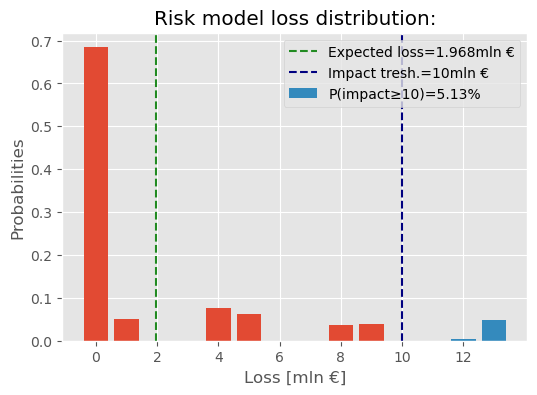

In [126]:
threshold = 10

plt.subplots(1,1, figsize=(6,4))

plt.bar(unique_joint_impacts, 
        uji_qps)
plt.bar(unique_joint_impacts[unique_joint_impacts>threshold], 
        uji_qps[unique_joint_impacts>threshold],
        label=f'P(impact≥{threshold})={100*uji_qps[unique_joint_impacts>threshold].sum()}%')

plt.axvline(10, color='navy', linestyle='--', label=f'Impact tresh.={threshold}mln €')

# plt.fill_between(x, y, color='firebrick', alpha=0.3, label=f'P(impact≥5)={100-100*dist.cdf(5):.2f}%')


plt.title('Risk model loss distribution:')
plt.xticks(range(0,14,2), [f'{x:.0f}' for x in range(0,14,2)])
plt.xlabel("Loss [mln €]")
plt.ylabel('Probabilities')

plt.legend()

plt.show()